In [1]:
import torch

import triton
import triton.language as tl
import matplotlib
import pandas as pd
import numpy as np


In [2]:
# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    # x = x + 1
    return tl.where(x >= 0, x, 0.01 * x)


In [86]:
# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=[
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 128}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 128}, num_stages=2, num_warps=4),
    ],
    key=['B', 'D', 'E'],
)
@triton.jit
def mlp_wide_kernel(
    # Pointers to matrices
    x_ptr, w1_ptr, w2_ptr, o_ptr,
    # Matrix dimensions
    H, B, D: tl.constexpr, E,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    # Meta-parameters
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr,
):
    """Kernel for computing the mlp
    Z = X @ W1, H = f(Z), O = H @ W2.
    - X has shape (B, D)
    - W1 has shape (D, E)
    - W2 has shape (E, D)
    - O has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    pid = tl.program_id(axis=0)
    batch_groups = tl.cdiv(B, BLOCK_SIZE_B)
    pid_b = pid % batch_groups
    pid_h = pid // batch_groups
    # tl.device_print('pid_H', pid_h)
    # tl.device_print('pid_B', pid_b)
    # pid_d = tl.program_id(axis=1)
    TARGET_TYPE = x_ptr.type.element_ty
    x_ptrs = tl.make_block_ptr(
        base=x_ptr,
        shape=(B * H, D),
        strides=(stride_xb, stride_xd),
        offsets=(pid_h * B + pid_b * BLOCK_SIZE_B, 0),
        block_shape=(BLOCK_SIZE_B, D),
        order=(1, 0),
    )
    w1_ptrs = tl.make_block_ptr(
        base=w1_ptr,
        shape=(D * H, E),
        strides=(stride_w1d, stride_w1e),
        offsets=(pid_h * D, 0),
        block_shape=(D, BLOCK_SIZE_E),
        order=(1, 0),
    )
    w2_ptrs = tl.make_block_ptr(
        base=w2_ptr,
        shape=(E * H, D),
        strides=(stride_w2e, stride_w2d),
        offsets=(pid_h * E, 0),
        block_shape=(BLOCK_SIZE_E, D),
        order=(1, 0),
    )
    o_ptrs = tl.make_block_ptr(
        base=o_ptr,
        shape=(B * H, D),
        strides=(stride_ob, stride_od),
        offsets=(pid_h * B + pid_b * BLOCK_SIZE_B, 0),
        block_shape=(BLOCK_SIZE_B, D),
        order=(1, 0),
    )
    x = tl.load(x_ptrs) # BLOCK_SIZE_B, D
    o = tl.zeros((BLOCK_SIZE_B, D), dtype=tl.float32)
    for e in range(0, tl.cdiv(E, BLOCK_SIZE_E)):
        # z = tl.zeros((BLOCK_SIZE_B, BLOCK_SIZE_E), dtype=tl.float32)
        # loop over D
        w1 = tl.load(w1_ptrs)       # D, BLOCK_SIZE_E
        w2 = tl.load(w2_ptrs)       # BLOCK_SIZE_E, D
        z = tl.dot(x, w1, out_dtype=tl.float32)        # BLOCK_SIZE_B, BLOCK_SIZE_E
        # activation
        if ACTIVATION == "leaky_relu":
            z = leaky_relu(z).to(TARGET_TYPE)
        else:
            z = z.to(TARGET_TYPE)
        # accumulate with o
        o = tl.dot(z, w2, o, out_dtype=tl.float32)        # BLOCK_SIZE_B, D
        # advance w1 and w2
        w1_ptrs = tl.advance(w1_ptrs, (0, BLOCK_SIZE_E))
        w2_ptrs = tl.advance(w2_ptrs, (BLOCK_SIZE_E, 0))
    o = o.to(TARGET_TYPE)
    # store o
    # tl.static_print('o_ptrs', o_ptrs, o)
    tl.store(o_ptrs, o)


In [87]:
def mlp_wide_triton(x, w1, w2, activation=""):
    # Check constraints.
    assert x.shape[0] == w1.shape[0], "Incompatible dimensions"
    assert x.shape[0] == w2.shape[0], "Incompatible dimensions"
    assert x.shape[2] == w1.shape[1], "Incompatible dimensions"
    assert w1.shape[2] == w2.shape[1], "Incompatible dimensions"
    assert x.shape[2] == w2.shape[2], "Incompatible dimensions"

    H, B, D = x.shape
    E = w1.shape[-1]

    # print(H, B, D, E)
    # print(x.shape, w1.shape, w2.shape)

    x = x.view(H * B, D)
    w1 = w1.view(D * H, E)
    w2 = w2.view(E * H, D)

    assert x.is_contiguous(), "Matrix X must be contiguous"
    assert w1.is_contiguous(), "Matrix W1 must be contiguous"
    assert w2.is_contiguous(), "Matrix W2 must be contiguous"

    # Allocates output.
    o = torch.empty_like(x)
    #print(x.shape, w1.shape, w2.shape, o.shape)
    # print(o.shape)

    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(B, META['BLOCK_SIZE_B']) * H,
    )
    mlp_wide_kernel[grid](
        x, w1, w2, o,
        H, B, D, E,
        x.stride(0), x.stride(1),
        w1.stride(0), w1.stride(1),
        w2.stride(0), w2.stride(1),
        o.stride(0), o.stride(1),
        ACTIVATION=activation
    )

    # print(o.shape)
    return o.reshape(H, B, D)


In [88]:
def mlp_torch(x, w1, w2, activation=""):
    z = torch.bmm(x, w1)
    if activation == "leaky_relu":
        z = torch.nn.functional.leaky_relu(z)
    o = torch.bmm(z, w2)
    return o


In [89]:
def unit_test_simple():
    # torch.manual_seed(115)
    dtype = torch.bfloat16
    B = 1024
    D = 16
    E = 768
    H = 12
    x = torch.randn((H, B, D), device='cuda', dtype=dtype)
    w1 = torch.randn((H, D, E), device='cuda', dtype=dtype)
    w2 = torch.randn((H, E, D), device='cuda', dtype=dtype)
    triton_output = mlp_wide_triton(x, w1, w2, activation="leaky_relu")
    torch_output = mlp_torch(x, w1, w2, activation="leaky_relu")
    print(f"triton_output={triton_output.shape, triton_output}")
    print(f"torch_output={torch_output.shape, torch_output}")
    if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=1e-2):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

    diff = np.abs(triton_output.to(torch.float32).cpu().numpy() - torch_output.to(torch.float32).cpu().numpy())
    print("max diff:",np.max(diff))
    print("mean diff:",np.mean(diff))

unit_test_simple()


triton_output=(torch.Size([12, 1024, 16]), tensor([[[  44.7500,  -26.2500,   -0.2539,  ...,   30.8750,  -35.0000,
           -14.3125],
         [  -5.9688,  -67.5000,   41.7500,  ...,   82.5000,  -10.5000,
           -16.2500],
         [ -40.2500,   70.5000, -127.5000,  ..., -114.5000,  -55.7500,
           -49.5000],
         ...,
         [   8.2500,   14.5625,   47.0000,  ...,  148.0000, -168.0000,
           -31.7500],
         [   1.2891,   94.0000,  -40.7500,  ...,   27.5000,   48.5000,
           189.0000],
         [ -48.0000,   84.5000,  -34.7500,  ...,  -10.0625,  -72.5000,
           161.0000]],

        [[ 102.5000,  -93.0000,    0.8984,  ...,   25.0000,   -4.8438,
            75.0000],
         [ 130.0000,   41.0000,  -66.5000,  ...,   65.0000,   71.5000,
          -104.5000],
         [  46.2500,  -34.5000,  -37.7500,  ...,   29.3750,  -73.0000,
            36.7500],
         ...,
         [ 119.0000,  -15.6250,  100.0000,  ...,  107.0000,  -63.7500,
           -10.6875

In [90]:
@triton.jit
def mlp_wide_backward(
    x, w1, w2, o, dx, dw1, dw2, do,
    H, B, D, E,
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    stride_dxb, stride_dxd,
    stride_dw1d, stride_dw1e,
    stride_dw2e, stride_dw2d,
    stride_dob, stride_dod,
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr
):
    pass


In [95]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['E'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            # 2 ** i for i in range(5, 12)
            128 * i for i in range(2, 16)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch-16', 'triton-16', 'torch-64', 'triton-64', 'torch-128', 'triton-128'],
        # Label name for the lines
        line_names=["Torch-16", "Triton-16", "Torch-64", "Triton-64", "Torch-128", "Triton-128"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark(E, provider):
    dtype = torch.bfloat16
    D = int(provider[provider.find('-') + 1:])
    HEAD = 768 // D
    L = 1024
    S = 4
    B = L * S
    x = torch.randn((HEAD, B, D), device='cuda', dtype=dtype)
    w1 = torch.randn((HEAD, D, E), device='cuda', dtype=dtype)
    w2 = torch.randn((HEAD, E, D), device='cuda', dtype=dtype)
    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('torch'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_torch(x, w1, w2, activation="leaky_relu"), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_wide_triton(x, w1, w2, activation="leaky_relu"), quantiles=quantiles)
    perf = lambda ms: 4 * B * D * E * HEAD * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


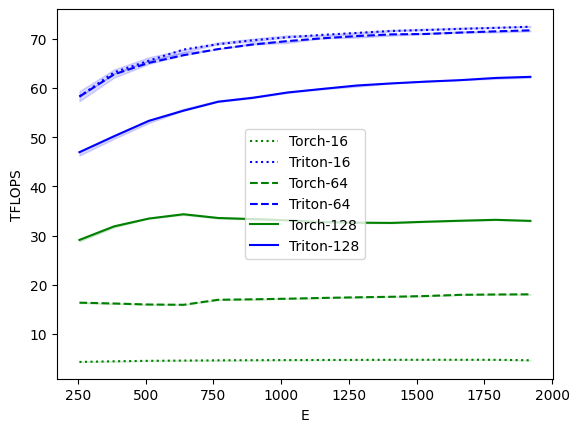

mlp-performance:
         E  Torch-16  Triton-16   Torch-64  Triton-64  Torch-128  Triton-128
0    256.0  4.350938  58.254222  16.383999  58.254222  29.127111   46.951164
1    384.0  4.481626  63.177800  16.215093  62.757668  31.882377   50.197786
2    512.0  4.572279  65.535998  16.010704  65.091041  33.465191   53.317422
3    640.0  4.626071  67.795860  15.953990  66.646778  34.342009   55.382533
4    768.0  4.674549  68.884557  16.973353  67.893412  33.584286   57.195053
5    896.0  4.703139  69.683850  17.069841  68.812802  33.363781   57.995315
6   1024.0  4.728640  70.295600  17.189771  69.518852  33.112925   59.074702
7   1152.0  4.746975  70.778882  17.347765  70.078101  32.768000   59.792085
8   1280.0  4.762196  71.170318  17.476267  70.532019  32.632033   60.494769
9   1408.0  4.775463  71.572377  17.582829  70.880569  32.582868   60.920787
10  1536.0  4.787790  71.765659  17.739068  70.956274  32.824987   61.280418
11  1664.0  4.788579  71.997294  17.983493  71.244710  33.0

In [96]:
benchmark.run(show_plots=True, print_data=True)
